In [13]:
%matplotlib agg

import copy

from utils.model import model_names_eps30, model_names_logr
from utils.ml import MLPNetwork, MOVotingRegressor
from utils.log import auto_log
from utils.vis_shap import summary_legacy

import shap
from shap.plots import colors
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import keras
from sklearn.utils import Bunch

# eps30

In [6]:
models_eps30 = []  

for model_name in model_names_eps30:
    tf.keras.backend.clear_session()
    
    f_model = f'data/eps30_models/{model_name}.model'
    model = tf.keras.models.load_model(f_model)
    
    mlp_model = MLPNetwork.from_keras(model)
    mlp_model.name = model_name
    last_layer = model.layers[-1]
    if isinstance(last_layer, keras.layers.Rescaling):
        mlp_model.output_scale = last_layer.scale

    models_eps30.append(mlp_model)                

perf_model_eps30 = MOVotingRegressor([(m.name, m) for m in models_eps30])
names, clfs = perf_model_eps30._validate_estimators()
perf_model_eps30.estimators_ = [clf for name, clf in zip(names, clfs) if name != 'drop']
perf_model_eps30.named_estimators_ = Bunch(**{name: clf for name, clf in zip(names, clfs) if name != 'drop'})

In [7]:
train_df = pd.read_csv('data/eps30_data/eps_train_rd08.csv')
x_cols = ['CNF', 'MXN', 'GEL', 'Mass_loading', 'GA']
X_train, y_train_1 = train_df[x_cols], train_df['eps_30']

explainer = shap.Explainer(perf_model_eps30.predict, X_train)
shap_values_eps30 = explainer(X_train)
shap_values_eps30_norm = copy.deepcopy(shap_values_eps30)
shap_values_eps30_norm.values /= np.max(np.abs(shap_values_eps30_norm.values))

Exact explainer: 163it [00:11,  1.36it/s]                                                                                                                                   


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.


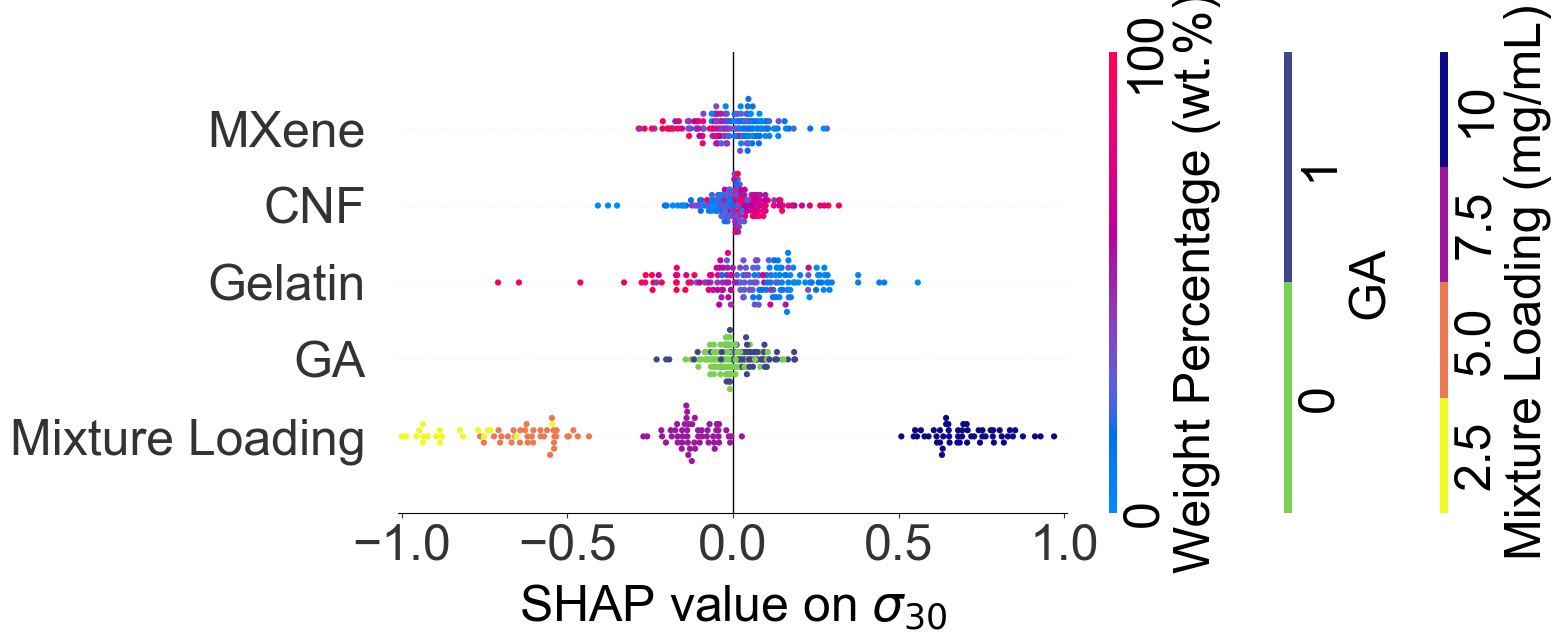

In [14]:
mpl.rcParams['font.family'] = 'Arial'

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 24
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=36)    # fontsize of the tick labels
plt.rc('ytick', labelsize=36)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.close('all')

tick_locs = [0.8, 0.2]
base1 = mpl.colormaps.get_cmap('viridis')
color_list1 = base1(tick_locs)
cmap_name1 = base1.name + str(len(tick_locs))
cmap1 = plt.cm.colors.ListedColormap(color_list1, name=cmap_name1)

tick_locs = [1.0, 2/3, 1/3, 0]
base2 = mpl.colormaps.get_cmap('plasma')
color_list2 = base2(tick_locs)
cmap_name2 = base2.name + str(len(tick_locs))
cmap2 = plt.cm.colors.ListedColormap(color_list2, name=cmap_name2)

x_label = ['CNF', 'MXene', 'Gelatin', 'Mixture Loading', 'GA']


X_train_plot = copy.deepcopy(X_train)
X_train_plot['Mass_loading'] /=10

shap_values_eps30_norm_plot = copy.deepcopy(shap_values_eps30_norm)
shap_values_eps30_norm_plot.data = X_train_plot.values

summary_legacy(shap_values_eps30_norm_plot, X_train_plot, 
               feature_names=x_label, sort=False, plot_size=(16,6), 
               plot_idx = np.array([3,4,2,0,1]),
               color_bar=False, dot_size=20,
                 cmaps=[colors.red_blue, colors.red_blue, colors.red_blue, 
                         cmap2, cmap1]
              )
fig = plt.gcf()
ax = plt.gca()

arts = []
for cmap, fraction, label, ticks, ticklabels in [
        (cmap2,           0.10, 'Mixture Loading (mg/mL)', [1/8, 3/8, 5/8, 7/8], ['2.5', '5.0', '7.5', '10']),
        (cmap1,           0.10, 'GA',    [1/4, 3/4], ['0', '1']),
        (colors.red_blue, 0.15, 'Weight Percentage (wt.%)', [0, 1], ['0', '100']),
        
    ]:
        m = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap=cmap, )
        # m.set_array([0, 1])
        cbar = fig.colorbar(m, ticks=ticks, shrink=1.0, fraction=fraction, pad=0.05, aspect=60)
        
#         cbar = fig.colorbar(s1, ax=ax, shrink=0.5, pad=0.02, label='Solubility Group', ticks=[1/4, 3/4])
        cbar.set_ticklabels(ticklabels, rotation=90, va='center', ma='center')
        cbar.minorticks_off()
        cbar.ax.tick_params(axis='y', length=0)
        cbar.set_label(label, labelpad=4, fontsize=36)
        cbar.ax.tick_params(length=0)
        cbar.set_alpha(1)
        cbar.outline.set_visible(False)
        arts.append(cbar.ax.yaxis.label)


ax.set_xlabel('SHAP value on $\mathit{σ_{30}}$', fontsize=36)
ax.set_xticks([-1,-0.5,0,0.5,1])
ax.set_xlim(-1.01, 1.010)
ax.xaxis.set_label_coords(.5, -.15)
fig.savefig('SHAP_sigma_30.pdf', bbox_inches='tight', bbox_extra_artists=arts)
fig.savefig('SHAP_sigma_30.svg', bbox_inches='tight', bbox_extra_artists=arts)

fig

# log R

In [15]:
models_logr = []  

for model_name in model_names_logr:    
    f_model = f'data/logr_models/{model_name}.model'
    model = tf.keras.models.load_model(f_model)
    
    mlp_model = MLPNetwork.from_keras(model)
    mlp_model.name = model_name
    last_layer = model.layers[-1]
    if isinstance(last_layer, keras.layers.preprocessing.image_preprocessing.Rescaling):
        mlp_model.output_scale = last_layer.scale
    
    models_logr.append(mlp_model)

perf_model_logr = MOVotingRegressor([(m.name, m) for m in models_logr])
names, clfs = perf_model_logr._validate_estimators()
perf_model_logr.estimators_ = [clf for name, clf in zip(names, clfs) if name != 'drop']
perf_model_logr.named_estimators_ = Bunch(**{name: clf for name, clf in zip(names, clfs) if name != 'drop'})    

In [16]:
train_logr = pd.read_csv('data/logr_data/logr_rd06_0DA.csv')
x_cols_logr = ['CNF', 'MXN', 'GEL', 'Mass_loading', 'GA']
X_train_logr, y_train_logr = train_logr[x_cols_logr], train_logr['log_resis']

explainer_logr = shap.Explainer(perf_model_logr.predict, X_train_logr)
shap_values_logr = explainer_logr(X_train_logr)
shap_values_logr_norm = copy.deepcopy(shap_values_logr)
shap_values_logr_norm.values /= np.max(np.abs(shap_values_logr_norm.values))


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.


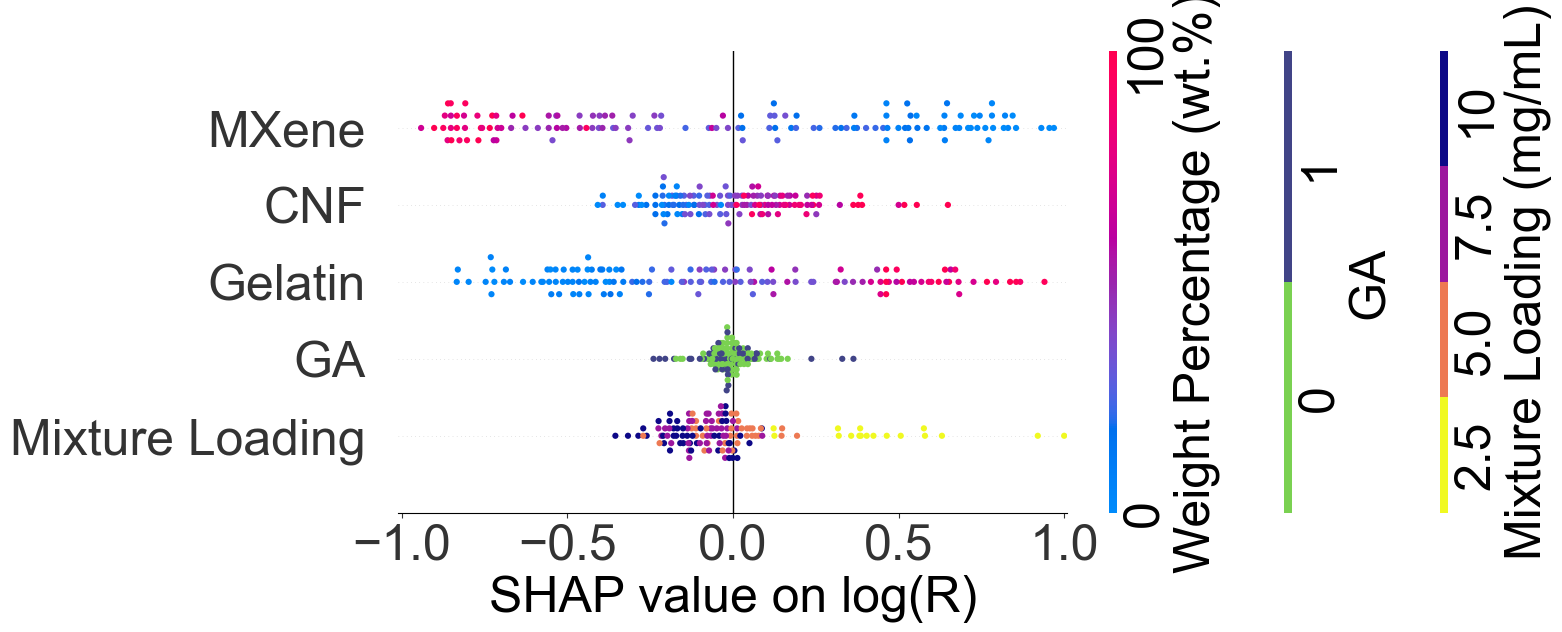

In [17]:
X_train_logr_plot = copy.deepcopy(X_train_logr)
X_train_logr_plot['Mass_loading'] /=10

shap_values_logr_norm = copy.deepcopy(shap_values_logr_norm)
shap_values_logr_norm.data = X_train_plot.values

plt.close('all')
summary_legacy(shap_values_logr_norm, X_train_logr_plot, 
               feature_names=x_label, sort=False, plot_size=(16,6), 
               plot_idx = np.array([3,4,2,0,1]),
               color_bar=False, dot_size=20,
                 cmaps=[colors.red_blue, colors.red_blue, colors.red_blue, 
                         cmap2, cmap1]
              )
fig = plt.gcf()
ax = plt.gca()

arts = []
for cmap, fraction, label, ticks, ticklabels in [
        (cmap2,           0.10, 'Mixture Loading (mg/mL)', [1/8, 3/8, 5/8, 7/8], ['2.5', '5.0', '7.5', '10']),
        (cmap1,           0.10, 'GA',    [1/4, 3/4], ['0', '1']),
        (colors.red_blue, 0.15, 'Weight Percentage (wt.%)', [0, 1], ['0', '100']),
        
    ]:
        m = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap=cmap, )
        # m.set_array([0, 1])
        cbar = fig.colorbar(m, ticks=ticks, shrink=1.0, fraction=fraction, pad=0.05, aspect=60)
        
#         cbar = fig.colorbar(s1, ax=ax, shrink=0.5, pad=0.02, label='Solubility Group', ticks=[1/4, 3/4])
        cbar.set_ticklabels(ticklabels, rotation=90, va='center', ma='center')
        cbar.minorticks_off()
        cbar.ax.tick_params(axis='y', length=0)
        cbar.set_label(label, labelpad=4, fontsize=36)
        cbar.ax.tick_params(length=0)
        cbar.set_alpha(1)
        cbar.outline.set_visible(False)
        arts.append(cbar.ax.yaxis.label)

ax.set_xlabel('SHAP value on log(R)', fontsize=36)
ax.set_xticks([-1,-0.5,0,0.5,1])
ax.set_xlim(-1.01, 1.01)
# fig.savefig('SHAP_log_R.pdf', bbox_inches='tight', bbox_extra_artists=arts)
# fig.savefig('SHAP_log_R.svg', bbox_inches='tight', bbox_extra_artists=arts)

fig